# Introduction

Ever notice how the view count on any YouTube MOOC (massive open online course) playlist falls with each lecture? No? Well I did and sought to visualize it! Using numerical analysis and data visualization with Python, I can find out for myself!

# Setup

To run this notebook yourself, create a YouTube Data API key here: https://console.developers.google.com and assign it to ```api_key``` below.

In [177]:
from apiclient.discovery import build
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# style.available
style.use('fivethirtyeight')

# YouTube Data API key
api_key = None

# Hypothesis

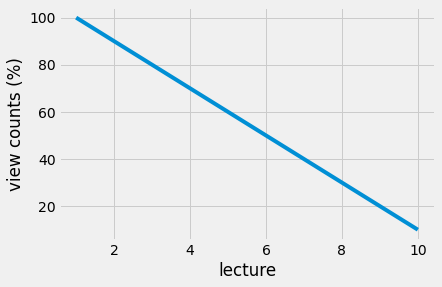

In [206]:
lecture = list(range(1,11))
view_counts = list(range(10,110,10))
view_counts.reverse()

fig,ax = plt.subplots()
ax.plot(lecture,view_counts)
ax.set_xlabel('lecture')
ax.set_ylabel('view counts (%)')
plt.show()

Based on observation, I predict the end result for the visualization of a MOOC playlist's lecture number vs. view count will look similar to this plot.

# Constraints

1.) Top 10 MIT courses from MIT's Most Visited Courses page if all video lectures exist on YouTube.

2.) No auxiliary videos (introductory videos, problem sets, recitations, etc.; quiz reviews that are an entire lecture are ok) or courses without in-class lectures.

After reviewing the courses and videos, I added the following contraints:

3.) No duplicate courses. Choose the one that appears first or the one that has in-class lectures (e.g. 6.042J, 18.01SC).

4.) Preserve lecture order in playlist, even if the correct order is lost (e.g. 18.03).

# Data Collection

In [207]:
playlists = {
    '6.0001': 'https://www.youtube.com/playlist?list=PLUl4u3cNGP63WbdFxL8giv4yhgdMGaZNA', \
    # all lecture video titles start with a number
    '18.01SC': 'https://www.youtube.com/playlist?list=PL590CCC2BC5AF3BC1', \
    # all videos, all lecture video titles start with 'Lec'
    '18.02SC': 'https://www.youtube.com/playlist?list=PL4C4C8A7D06566F38', \
    # all videos, all lecture video titles start with 'Lec'
    '6.006': 'https://www.youtube.com/playlist?list=PLUl4u3cNGP61Oq3tWYp6V_F-5jb5L2iHb', \
    # all lecture video titles start with a number
    '18.06': 'https://www.youtube.com/playlist?list=PLE7DDD91010BC51F8', \
    # all lecture videos start with a number
    '18.03': 'https://www.youtube.com/playlist?list=PL64BDFBDA2AF24F7E', \
    # all lecture video titles start with 'Lec'
    '6.00SC': 'https://www.youtube.com/playlist?list=PLB2BE3D6CA77BB8F7', \
    # all lecture video titles start with 'Lec'
    '6.042J': 'https://www.youtube.com/playlist?list=PLB7540DEDD482705B', \
    # all lecture video titles start with 'Lec'
    '14.01SC': 'https://www.youtube.com/playlist?list=PL61533C166E8B0028', \
    # all lecture video titles start with 'Lec'
    '6.0002': 'https://www.youtube.com/playlist?list=PLUl4u3cNGP619EG1wp0kT-7rDE_Az5TNd' \
    # all lecture video titles start with a number
}

# Note: every lecture video title starts with "Lec" or a number.

In [180]:
len(playlists)

10

In [181]:
youtube = build('youtube', 'v3', developerKey=api_key)

Create a function that to get course's view count from a playlist url:

In [182]:
def get_view_counts(course, playlist_url):
    '''
    Takes a MIT course number and YouTube playlist url, filters the lecture videos,
    and returns the view counts in sequential order.
    '''
    
    video_ids = []
    view_counts = [course]    
    
    # Get playlist id from url.
    playlist_id = playlist_url.split('=')[1]
    
    # Call API to get playlist videos snippets.
    res1 = youtube.playlistItems().list(playlistId=playlist_id, 
                                       part='snippet', 
                                       maxResults=50).execute()

    
    # Get title and video id from snippet.
    for item in res1['items']:
        title = item['snippet']['title']
        video_id = item['snippet']['resourceId']['videoId']
        
        # Filter lecture videos.
        if (title.startswith('Lec') or title[:1].isdigit()): 
#             print(title, video_id) # Uncomment line to check that correct videos were filtered.
            video_ids.append(video_id)
    
    
    # Convert video ids list to string csv.
    video_ids = ','.join(video_ids)
    
    # Call API to get bulk video statistics.
    res2 = youtube.videos().list(id=video_ids, part='statistics').execute()
    
    # Filter view count from statistics and append to view count list.
    for item in res2['items']:
        video_id = item['id']
        views = item['statistics']['viewCount']
#         print(video_id, views) # Uncomment line to check that video ids match correct videos.
        view_counts.append(views)
    
    return view_counts

Test function on 6.0001:

In [183]:
get_view_counts('6.0001',playlists['6.0001'])

['6.0001',
 '245639',
 '218053',
 '144435',
 '93806',
 '95531',
 '155148',
 '74502',
 '282658',
 '92442',
 '102283',
 '50128',
 '70688']

Loop through playlists dictionary appending view counts to the master list:

In [184]:
master = []
for key,val in playlists.items():
    master.append(get_view_counts(key,val))

In [185]:
len(master)

10

# Data Cleaning

Convert master list to pandas DataFrame:

In [186]:
df = pd.DataFrame(master)

In [211]:
df.iloc[:5,:5]

MIT Course,6.0001,18.01SC,18.02SC,6.006,18.06
1,245639.0,1330817.0,1133117.0,2818032.0,214967.0
2,218053.0,555491.0,368820.0,535328.0,1269114.0
3,144435.0,380011.0,275495.0,552127.0,951820.0
4,93806.0,251447.0,217260.0,590530.0,311902.0
5,95531.0,244137.0,202920.0,425131.0,571257.0


Set course number column as index:

In [188]:
df = df.set_index(0)

Transpose DataFrame so courses are on top:

In [189]:
df = df.T

Rename columns name for plot legend:

In [190]:
df.columns.name = 'MIT Course'

Check the data types:

In [191]:
df.dtypes

MIT Course
6.0001     object
18.01SC    object
18.02SC    object
6.006      object
18.06      object
18.03      object
6.00SC     object
6.042J     object
14.01SC    object
6.0002     object
dtype: object

Convert data type to float:

In [192]:
df = df.astype(float)

In [193]:
df.dtypes

MIT Course
6.0001     float64
18.01SC    float64
18.02SC    float64
6.006      float64
18.06      float64
18.03      float64
6.00SC     float64
6.042J     float64
14.01SC    float64
6.0002     float64
dtype: object

Finally, let's scale the data using min-max normalization (column-wise):

In [194]:
df_norm = (df-df.min()) / (df.max() - df.min())

The cleaned data:

In [212]:
df_norm.head()

MIT Course,6.0001,18.01SC,18.02SC,6.006,18.06,18.03,6.00SC,6.042J,14.01SC,6.0002
1,0.840799,1.000000,1.000000,1.000000,0.164587,1.000000,1.000000,1.000000,1.000000,0.288494
2,0.722165,0.388700,0.287818,0.174093,1.000000,0.144054,0.338376,0.271164,0.307682,0.109286
3,0.405569,0.250345,0.200856,0.180171,0.748544,0.149971,0.189771,0.150367,0.178949,0.049547
4,0.187838,0.148979,0.146592,0.194066,0.241408,0.041882,0.134033,0.149112,0.169815,0.071918
5,0.195257,0.143216,0.133230,0.134222,0.446948,0.019738,0.087455,0.065431,0.090308,0.083206


# Data Visualization

Let's begin by getting a visual overview of each course.

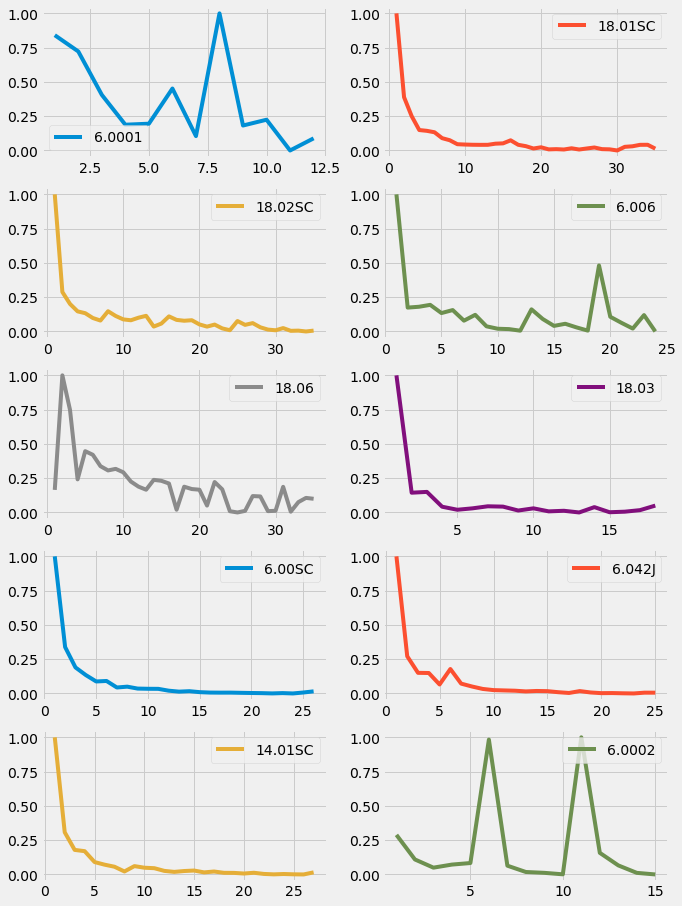

In [196]:
# fig, axes = plt.subplots(figsize=(10, 15), nrows=5, ncols=2)
# df_norm.plot(subplots=True, ax=axes)
# plt.show()

df_norm.plot(subplots=True, layout=(5, 2), figsize=(10, 15), sharex=False)
plt.show()

The above plots look nothing like the hypotheis. Let's add a linear trend line to each plot to see if they look something like the hypothesis.

In [210]:
def poly_fit(series,degree):
    '''
    Returns a polynomial curve that fits the data passed with selected degree.
    '''
    x = series.dropna().index
    y = series.dropna()
    z = np.polyfit(x,y,degree)
    p = np.poly1d(z)
    return p(x)

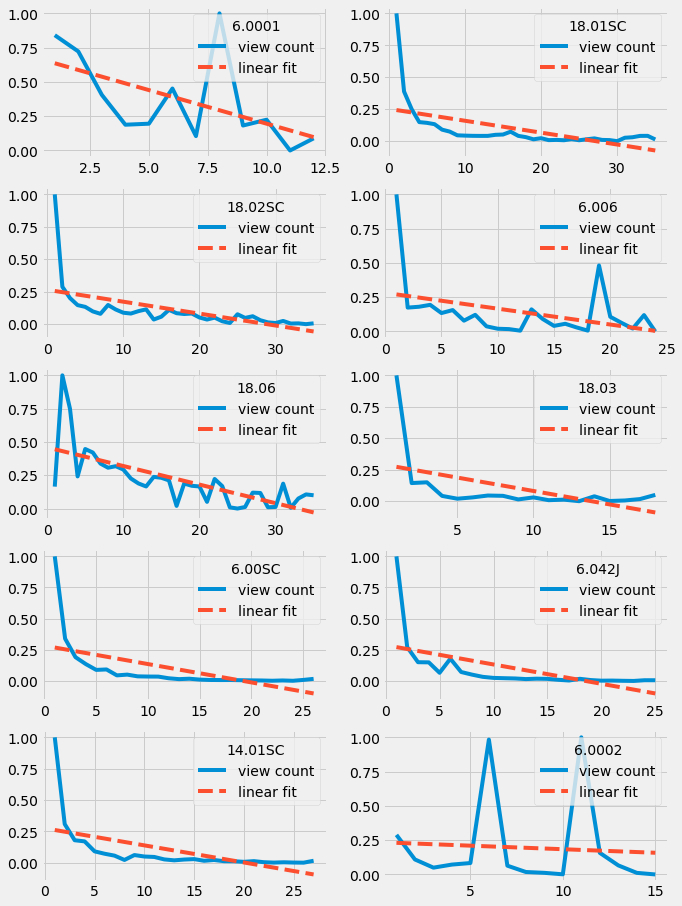

In [198]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=False)

for ax,col in zip(axs.reshape(-1),df_norm.columns):
    x = df_norm[col].dropna().index
    y = df_norm[col].dropna()
    
    ax.plot(x, y, label='view count')
    ax.plot(x, poly_fit(df_norm[col],1), '--', label='linear fit')
    ax.legend(title=col)
    
plt.show()

The linear trend lines are similar to the predicted plot, but don't fit the data well. Perhaps an exponential curve would be a better fit for every course except 6.0001 and 6.0002 (the first and last plots).

In [208]:
# Define exponential function.
def exp(x, a, b, c):
    return a * np.exp(-b*x) + c

# Get exponential fit from data.
def exp_fit(x, y):
    '''
    Fits an exponential curve to the data passed and returns (x2,y2) to plot the curve.
    '''
    
    p0 = (1.,1.,1.)
    opt, pcov = curve_fit(exp, x, y, p0)
    a,b,c = opt
    
    x2 = np.linspace(0,50)
    y2 = exp(x2, a, b, c)
    
    return x2,y2

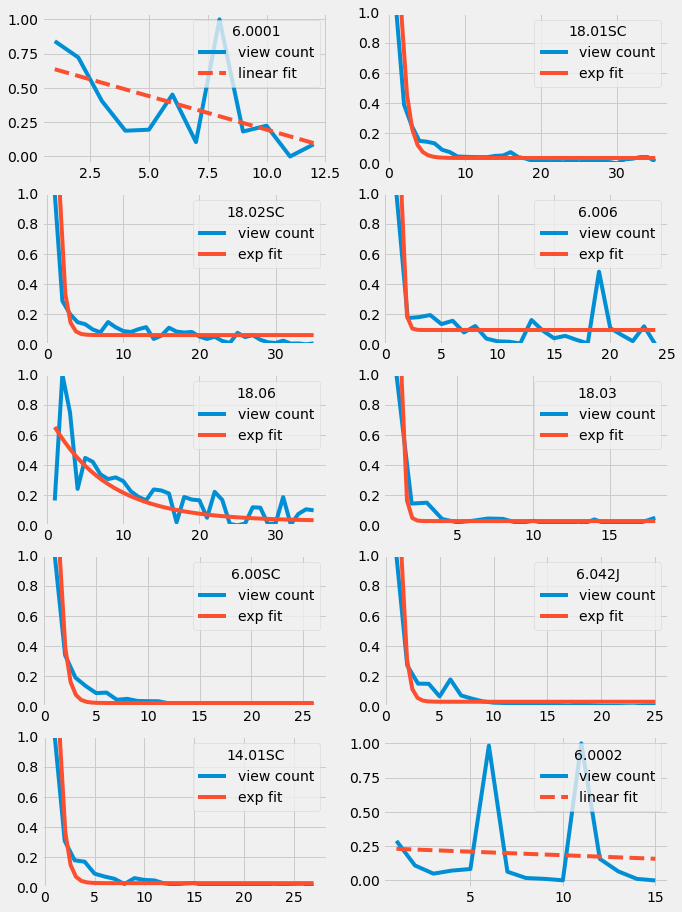

In [200]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,15), sharex=False)

for ax,col in zip(axs.reshape(-1),df_norm.columns):
    
    x = df_norm[col].dropna().index
    y = df_norm[col].dropna()
    
    if col in ['6.0001', '6.0002']:
        ax.plot(x, y, label='view count')
        ax.plot(x, poly_fit(df_norm[col],1), '--', label='linear fit')
        ax.legend(title=col)
    else:
        ax.plot(x, y, label='view count')
        ax.plot(np.linspace(1,len(x)), exp_fit(x,y)[1], '-', label='exp fit')
        ax.set_ylim([0, 1])
        ax.legend(title=col)
    
plt.show()

There appear to be a few courses (6.0001, 6.006, 18.06, 6.0002) that have sudden peaks which represent a spike in view count. Let's see what those are.

In [201]:
noteworthy = [('6.0001', [8]), ('6.006', [19]), ('18.06', [2]), ('6.0002', [6,11])]

In [209]:
def get_title(course, index, playlist_url):
    '''
    Get the titles of selected indices of a course. 
    '''
    
    titles = [course]    
    
    # Get playlist id from url.
    playlist_id = playlist_url.split('=')[1]
    
    # Call API to get playlist videos snippets.
    res = youtube.playlistItems().list(playlistId=playlist_id, 
                                       part='snippet', 
                                       maxResults=50).execute()
    # Get title from snippet.
    for item in res['items']:
        title = item['snippet']['title']
        
        # Filter lecture videos.
        if (title.startswith('Lec') or title[:1].isdigit()):
            titles.append(title)
    
    print(course)
    for item in index:
        print(titles[item])
        

In [203]:
for item in noteworthy:
    get_title(item[0], item[1], playlists[item[0]])

6.0001
8. Object Oriented Programming
6.006
19. Dynamic Programming I: Fibonacci, Shortest Paths
18.06
2. Elimination with Matrices.
6.0002
6. Monte Carlo Simulation
11. Introduction to Machine Learning


The sudden peaks could be attributed to more people watching the more difficult topics (object-oriented programming) or the more interesting ones (introduction to machine learning). Finally, let's plot the entire data.

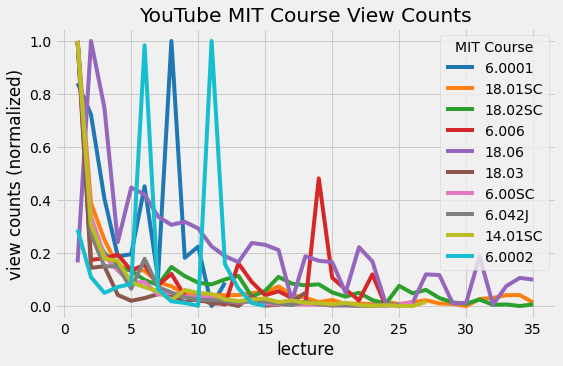

In [204]:
num_colors = len(df_norm.columns)

cm = plt.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(8,5))
ax.set_title('YouTube MIT Course View Counts')
ax.set_xlabel('lecture')
ax.set_ylabel('view counts (normalized)')
ax.set_prop_cycle('color', [cm(i/num_colors) for i in range(num_colors)])

for col in df_norm.columns:
    x = df_norm[col].index
    y = df_norm[col]
    ax.plot(x,y, label=col)

ax.legend(title=df_norm.columns.name)
plt.show()

# Conclusion

After collecting, cleaning, and visualizing YouTube MIT course playlist view count data, it is clear that view count does not fall linearly with each lecture. It seems to drop exponentially, which is sad because that means most people who start watching an MIT course on YouTube quit watching after the first few lectures. In fact, I am guilty of this myself. However, with this knowledge, I'll see to it that I finish at least one course from A to Z. Happy learning!

# Resources

MIT OCW Most Visited Courses: https://ocw.mit.edu/courses/most-visited-courses/

Exploring YouTube Data API: https://www.youtube.com/playlist?list=PLyb_C2HpOQSBJRh38CTPvsouV4SBpyt_H